# chapter. 8 Analyzing NGS Data

- NGS：二代测序技术，能够快速检测大量数据综合分析基因信息。NGS平台执行大规模的并行测序，从单个样本中提取的数百万个DNA片段被并行测序，从而促进了高通量测序。这使得整个基因组的测序速度更快，成本更低。

- NGS是一个术语，用来描述许多不同的现代测序技术。
它包括一些流行的技术：

> - Illumina (Solexa)测序  
- Roche 454测序  
- 半导体测序：质子和PGM测序  
- SOLiD sequencing ：Sequencing by Oligo Ligation Detection,即寡聚物连接检测测序

- 在NGS中最流行的序列数据格式之一是FASTQ格式。
在详细讨论NGS数据分析之前，先来看看FASTQ数据格式。
FASTQ数据格式由四行组成。
第一行是序列名，第二行是序列本身，第三行是关于序列的可选信息，第四行是对基的置信度或准确性度量。FASTQ格式以ASCII字符(通常，(33+Q)th ASCII字符用于表示Q值)的形式显示此质量度量。

- 让我们讨论一下质量分数。
NGS中的数据质量是用Phred评分度量的。
在测序过程中，每个碱基分配一个Phred分数;
因此，我们对FASTQ数据中的每个基都有一个对应的字符。数学上，Phred分数(Q)定义如下:

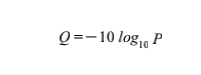

> P为基调用(将基分配到峰值的过程)中估计的错误概率。这在质量Q和基础调用错误P之间建立了一个对数关系.这允许您处理非常小的错误(接近于零)，并处理高精确度的数值。因此，99.999%(P=0.00001)的基础调用准确率得到50分。

---

## 1. Querying the SRA database

- *序列读库(Sequence Read Archive, SRA)*是一个数据库，它包含了通过不同平台获得的高通量测序产生的短读的DNA测序数据。
这些序列的长度通常小于1000个碱基对。该数据库可从http://www.ncbi.nlm.nih.gov/sra  获得。

(1)下载和加载 SRA包，

In [1]:
library(SRAdb)

Loading required package: RSQLite

Loading required package: graph

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: RCurl

Setting

(2)从SRA服务器获取元数据文件  ！！很慢。。。

In [ ]:
sqlFile <- getSRAdbFile()

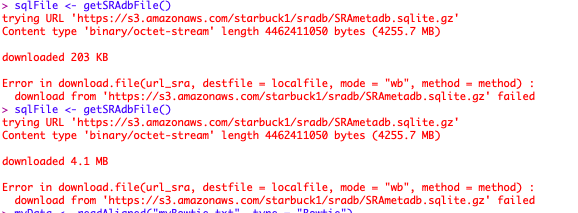

(3)创建一个到SQLite文件的查询连接

In [ ]:
sraCon <- dbConnect(SQLite(),sqlFile)

(4)调查数据库的内容。
这将帮助您定义稍后应该运行的查询。
使用以下函数来确定数据中的字段

In [ ]:
sraTables <- dbListTables(sraCon)
dbListFields(sraCon,"study")

(5)构建您的第一个查询，以从SRA研究中获得包含关键字 -*胚胎*- 的研究类型的资料和标题。
该查询可以看作是一个典型的SQL查询:

In [ ]:
myHit <- dbGetQuery(sraCon, paste("select study_accession,study_title from study where","study_description like'%embryo'",sep=" 
"))

In [ ]:
myHit  #查看查询结果#

(6)使用以下功能来搜索感兴趣的词语

In [ ]:
myHit1<- getSRA( search_terms = "brain", out_types = c('run','study'), sraCon)

In [ ]:
head(myHit1)

(7)关键词有多个的情况

In [ ]:
myHit2<- getSRA( search_terms ='Alzheimers OR "EPILEPSY"', out_types = c('sample'), sraCon)

In [ ]:
head(myHit2)

>SRAdb包使得对与提交、研究、示例、实验和运行相关的元数据的访问变得更加容易和快速(在配方的第二步中下载的SQLite数据库)。
SRAdb包通过来自NCBI SRA数据库的元数据工作。
dbConnect函数首先将R系统连接到这些本地数据库
所有查询都是基于其中包含的数据在本地处理的。
在这个菜谱中，我们使用dbGetQuery函数尝试的查询以SQL查询的形式传递，SQL查询是一个Select From Where框架。

---

## 2.Downloading data from the SRA database

- we can use the SRAdb
package to download the FASTQ data based on our queries.在刚刚查询到数据的基础上下载FASTQ数据。我们将需要希望搜索的查询或希望检索的数据的ID。

(1)加载SRA，用上一节的方法构“阿尔茨海默症“or“癫痫”的查询，（该步骤需要在上一个配方中创建的sraCon对象）

In [ ]:
 myHit <- getSRA( search_terms ='ALZHEIMERS OR "EPILEPSY"', out_types = c('sample'), sraCon)

In [ ]:
 myHit  #查询结果，并点击两个ID号

In [ ]:
conversion <- sraConvert( c('ERS354366','SRS266589'), sra_con = sraCon)  #使用SRAconvert功能

In [ ]:
conversion #查看刚刚创建的对象

(2)搜索上面得到的对象其中一个的实验信息，使用getSRAinfo函数

In [ ]:
 rs <- getSRAinfo( c("SRX100465"), sraCon, sraType = "sra")

In [ ]:
rs #提供了FTP地址和实验细节

(3)要下载感兴趣的数据，使用getSRAfile函数（take a lot of time)

In [ ]:
getSRAfile( c("SRR351672", "SRR351673"), sraCon, fileType ='fastq')

>The step where the recipe deviates is the conversion of the IDs from the results of the query for free text search. 
This gives us the accession IDs for the hits retrieved from SRA. 
Then, we collect the downloaded information on the data. 
Finally, the getSRAfile function fetches the file from the SRA database. 
This part of the recipe actually downloads the data from the remote host. 
We can also use the FTP address directly to download the file. 


---

## 3. Reading FASTQ files in R读取R中的FASTQ文件

- FASTQ文件可以有几个短序列读取。
它是NGS社区和大多数对齐程序(如Bowtie)中普遍接受的格式，Bowtie使用这些文件作为输入。为了分析数据，我们需要在工作空间中读入这些数据

- 本节需要一个FASTQ文件和一个ShortRead包。FASTQ文件可以从SRA数据库加载或者使用ShortRead包的示例。

(1)下载文件并载入r

In [ ]:
install.packages("R.utils")
library(R.utils)
download.file(url="ftp://ftp.ddbj.nig.ac.jp/ddbj_database/dra/fastq/SRA000/SRA000241/SRX000122/SRR000648.fastq.bz2", destfile = 
"SRR000648.fastq.bz2")
 bunzip2(list.files(pattern = ".fastq.bz2$"))  #解压下载的文件

> 也可以通过终端下载FASTQ文件如下

In [ ]:
$ cd <path/to working/directory>
$ wget ftp://ftp.ddbj.nig.ac.jp/ddbj_database/dra/fastq/SRA000/SRA000241/SRX000122/SRR000648.fastq.bz2
$ bunzip2 SRR000648.fastq.bz2   #将下载的文件解压到工作目录中

(2) 下载加载ShortRead包

In [ ]:
BiocManager::install("ShortRead")
library(ShortRead)

(3)用readFastq读取下载的文件。

In [ ]:
MyFastq <- readFastq(getwd(), pattern=".fastq")

In [ ]:
readLines("SRR000648.fastq", 4)  #读取前四行

> 读取FASTQ文件的函数通过读取行来工作。
它读取与被扫描目录中的给定模式匹配的所有fastq格式文件。
该函数从编译成R对象的FASTQ文件中返回序列和质量分数。
我们只是使用fastq$作为模式和当前工作目录
(getwd())作为被扫描的目录。

---

## 4. Reading alignment data

- NGS实验的输出是序列读取，必须对其进行比对并映射到参考基因组。
NGS数据分析的第一步是将读序列对齐到参考基因组。
由于大量的NGS数据和参考基因组，校准的任务在计算上非常困难。
然而，除了R之外，还有其他工具可以做到这一点。
最常用的校准工具包括BWA和Bowtie。

- 将FASTQ文件中的读操作映射到参考基因组之后，我们得到的是一个序列对齐映射(SAM)或BAM (SAM的二进制版本)文件。
本节将讨论如何在R工作区中读取/加载这些文件

(1)我们将需要Rsamtools包来读取BAM文件。这里使用的示例数据
此配方可从UCSC获得，用于演示目的。数据实际上是一个序列集样本
(NA12878)来自1000基因组计划。下载加载示例，下载加载Rsample包使用scanBam读取文件

In [ ]:
 download.file(url="http://genome.ucsc.edu/goldenPath/help/examples/bamExample.bam", destfile = "bamExample.bam")

In [ ]:
BiocManager::install("ShortRead")
library(Rsamtools)
bam <- scanBam("bamExample.bam")

In [ ]:
 names(bam[[1]])  #取数据的第一个列表元素的属性

(2)检查数据中的记录数目

In [ ]:
 countBam("bamExample.bam")

>  <font color = red>scanBam函数与countBam的输入函数一起导入NGS分析中的二进制对齐映射。</font>



-  如果只想读取选定的属性：

In [ ]:
what <- c("rname", "strand", "pos", "qwidth", "seq")
param <- ScanBamParam(what=what)
bam2 <- scanBam("bamExample.bam", param=param)
names(bam2[[1]])

>  <font color = red>what参数定义必须从数据导入的属性</font>

(3)读取为DataFrame对象:

In [ ]:
bam_df <- do.call("DataFrame", bam[[1]])
head(bam_df)

 > <font color = red> 导入的文件以列表的形式存储，每个元素都是对齐的。
列表可以很容易地转换为data.frame对象，
作为data.frame对象，列表中的每个条目都是一行和对齐的属性
以列的形式显示 

(4)提取数据框中满足某些条件的序列

In [ ]:
table(bam_df$rname == '21' & bam_df$flag == 16)

> <font color = red> 我们使用表函数来确定有多少
文件中的序列满足所需的条件.

---

## 5. Preprocessing the raw NGS data 预处理原始的NGS数据

- FASTQ数据以ASCII字符的形式将序列(碱基)作为相应的质量分数(Phred)，旦读入R工作区，数据就可以进行分析了。根据一些情况，它需要一些预处理来满足所需的质量和数据实例条件：例如我们需要更高的Phred分数和一个特定的链。这种预处理包括质量评估和过滤。本节对数据进行预处理：从数据检索到过滤。

(1)下载需要的文件

In [ ]:
 download.file(url="ftp://ftp.ddbj.nig.ac.jp/ddbj_database/dra/fastq/SRA000/SRA000241/SRX000122/SRR000648.fastq.bz2", destfile= 
"SRR000648.fastq.bz2")

In [ ]:
 download.file(url="ftp://ftp.ddbj.nig.ac.jp/ddbj_database/dra/fastq/SRA000/SRA000241/SRX000122/SRR000657.fastq.bz2", destfile= 
"SRR000657.fastq.bz2")

In [ ]:
library(R.utils) #解压

bunzip2(filename=list.files(pattern = ".fastq.bz2$")[1])  #解压并移除原来的压缩包

(2)用 ShortRead 包的 FastQuality功能进行质量评估

In [ ]:
 library(ShortRead)

In [ ]:
myFiles <- list.files(getwd(), "fastq", full=TRUE)
myFQ <- lapply(myFiles, readFastq)
myQual <- FastqQuality(quality(quality(myFQ[[1]])))

In [ ]:
readM <- as(myQual, "matrix")    #将质量评估结果转换为矩阵

In [ ]:
boxplot(as (data.frame(readM)), outline = FALSE, main="Per Cycle Read Quality", xlab="Cycle", ylab="Phred Quality")
# 将结果可视化为箱线图 x轴表示循环，y轴表示循环

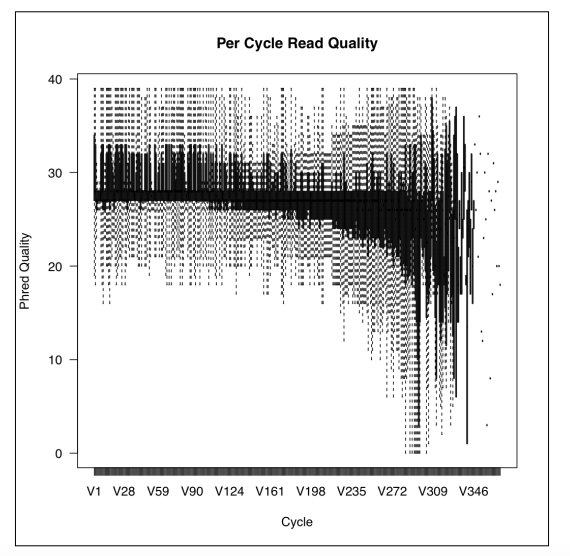

(3)另一个预处理的方法是在读取对齐序列时过滤序列：需要下载myBowtie.txt文件

In [ ]:
 myData <- readAligned("myBowtie.txt", type = "Bowtie")

In [ ]:
myData  #检查对齐

(4)可以使用不同的筛选器，如染色体、序列长度、链等等。
要使用这些，首先定义所需的过滤器(在这种情况下，为+链定义一个过滤器)如下:

In [ ]:
strand <- strandFilter("+")  #定义过滤器

In [2]:
 myRead_strand <- readAligned("myBowtie.txt", filter=strand, type = "Bowtie")  #使用刚才定义的过滤器

ERROR: Error in readAligned("myBowtie.txt", filter = strand, type = "Bowtie"): 没有"readAligned"这个函数


In [ ]:
chromosome <- chromosomeFilter("3") #定义多个过滤器

In [ ]:
 myFilt <- compose(strand, chromosome)

In [ ]:
 myRead_filt <- readAligned("myBowtie.txt", filter=Myfilt, type = "Bowtie")

In [ ]:
myRead_filt  #查看结果

> 本配方中描述的质量检查功能使用FASTQ文件中以ASCII字符形式分配的Phred分数，并计算每个周期的实际质量分数。
这反映在我们之前看到的箱线图中。
过滤函数只是检查数据并提取满足过滤条件的对齐读取。
可以使用的其他过滤器包括idFilter、positionFilter等。
我们可以看到使用+和-链进行1,000次读取的myData对象之间的差异，而经过筛选的对象myRead_filt使用+链只进行了55次读取。

---

## 6.Analyzing RNAseq data with the edgeR package

- 以确定转录本的计数是否存在显著差异或
在处理条件下的差异表达，我们需要对数据进行差异计数分析。
这类似于第5章中介绍的用r分析微阵列数据的差异基因分析。我们将使用本配方中的edgeR包进行这样的分析。

(1)我们将需要两个R包，即edgeR和goseq的配方。在数据集方面，我们将演示这些包的默认数据。这些数据来自一项实验，该实验检测了雄激素刺激对人类前列腺癌细胞株LNCaP的影响。数据有四个对照和三个处理过的样本。

In [5]:
library(edgeR)
library(goseq)

Loading required package: limma

Loading required package: BiasedUrn

Loading required package: geneLenDataBase





In [11]:
myData <- read.table(system.file("extdata", "Li_sum.txt", package='goseq'), sep = '\t', header = TRUE, stringsAsFactors = FALSE,row.names=1)    #用geseq包的读如数据

In [12]:
head(myData)   #查看数据库内容

,lane1,lane2,lane3,lane4,lane5,lane6,lane8
,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000215688,0,0,0,0,0,0,0
ENSG00000215689,0,0,0,0,0,0,0
ENSG00000220823,0,0,0,0,0,0,0
ENSG00000242499,0,0,0,0,0,0,0
ENSG00000224938,0,0,0,0,0,0,0
ENSG00000239242,0,0,0,0,0,0,0


(2)数据中的前四列是对照控制组，最后三列是处理
示例。将这些属性赋值给数据如下:

In [27]:
myTreat <- factor(rep(c("Control","Treatment"),times = c(4,3)))
myTreat

[1] Control   Control   Control   Control   Treatment Treatment Treatment
Levels: Control Treatment

(3)使用所有计数数据和处理信息创建DGElist对象.edgeR包通过一个过分散的泊松模型(假设它是一个负二项分布)来建模计数数据。然后，它遵循经验贝叶斯程序，通过条件极大似然来调节基因间的过度分散程度，条件是该基因的总计数(步骤5)。

In [44]:
library(edgeR)
myDG <- DGEList(myData,lib.size = colSums(myData),group = myTreat)
myDG

Loading required package: limma



,lane1,lane2,lane3,lane4,lane5,lane6,lane8
ENSG00000215688,0,0,0,0,0,0,0
ENSG00000215689,0,0,0,0,0,0,0
ENSG00000220823,0,0,0,0,0,0,0
ENSG00000242499,0,0,0,0,0,0,0
ENSG00000224938,0,0,0,0,0,0,0
ENSG00000239242,0,0,0,0,0,0,0
ENSG00000243140,0,0,0,0,0,0,0
ENSG00000240187,0,0,0,0,0,0,0
ENSG00000241444,0,0,0,0,0,0,0
ENSG00000242468,0,0,0,0,0,0,0


(4)估计数据中的离散度:

In [45]:
myDisp <- estimateCommonDisp(myDG)  
myDisp

,lane1,lane2,lane3,lane4,lane5,lane6,lane8
ENSG00000215688,0,0,0,0,0,0,0
ENSG00000215689,0,0,0,0,0,0,0
ENSG00000220823,0,0,0,0,0,0,0
ENSG00000242499,0,0,0,0,0,0,0
ENSG00000224938,0,0,0,0,0,0,0
ENSG00000239242,0,0,0,0,0,0,0
ENSG00000243140,0,0,0,0,0,0,0
ENSG00000240187,0,0,0,0,0,0,0
ENSG00000241444,0,0,0,0,0,0,0
ENSG00000242468,0,0,0,0,0,0,0


In [46]:
mytest <- exactTest(myDisp)     #Fisher测试，得到相应的统计分数
mytest

,logFC,logCPM,PValue
,<dbl>,<dbl>,<dbl>
ENSG00000215688,0,0.330418,1
ENSG00000215689,0,0.330418,1
ENSG00000220823,0,0.330418,1
ENSG00000242499,0,0.330418,1
ENSG00000224938,0,0.330418,1
ENSG00000239242,0,0.330418,1
ENSG00000243140,0,0.330418,1
ENSG00000240187,0,0.330418,1
ENSG00000241444,0,0.330418,1


(5)用以下topTags函数提取按p值(或绝对对数变化)排序的top DE标签:

In [49]:
myRes <- topTags(mytest, sort.by = "PValue")    # 返回顶级标签(根据p-值)

In [48]:
 head(myRes)

,logFC,logCPM,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000127954,11.557868,6.680748,2.574972e-80,1.274766e-75
ENSG00000151503,5.398963,8.499530,1.781732e-65,4.410322e-61
ENSG00000096060,4.897600,9.446705,7.983756e-60,1.317479e-55
ENSG00000091879,5.737627,6.282646,1.207655e-54,1.494654e-50
ENSG00000132437,-5.880436,7.951910,2.950042e-52,2.920896e-48
ENSG00000166451,4.564246,8.458467,7.126763e-52,5.880292e-48


---

## 7.The differential analysis of NGS data using limma

- limma可以用来差异基因表达分析，另一个由limma软件包提供，它使用R来分析微阵列数据。它可以通过经验贝叶斯统计方法处理多个实验，并对每个基因使用归一化读计数。
本节将解释使用来自Bioconductor的limma软件包进行NGS数据的差异基因分析。

(1）除了limma包，还需要pasilla的数据包

In [50]:
library(limma)
library(DESeq)
library(pasilla)

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: Biobase

Welcom

In [51]:
data(pasillaGenes)
pasillaGenes

CountDataSet (storageMode: environment)
assayData: 14470 features, 7 samples 
  element names: counts 
protocolData: none
phenoData
  sampleNames: treated1fb treated2fb ... untreated4fb (7 total)
  varLabels: sizeFactor condition type
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
  pubMedIds: 20921232 
Annotation:  

(2)使用来自pasillaGenes数据集的计数创建表达式数据集

In [67]:
eset <- counts(pasillaGenes)

> <font color= red>与第五章limma分析微阵列数据不同的是 ，我们使用count数据来代替规范化的表达式值。

(3)数据中的前三列是处理组，最后四列是处理
示例。将这些属性赋值给数据如下

In [54]:
colnames(eset) <- c(paste("T", 1:3, sep="_"), paste("C", 1:4, sep="_"))
head(eset)

,T_1,T_2,T_3,C_1,C_2,C_3,C_4
FBgn0000003,0,0,1,0,0,0,0
FBgn0000008,78,46,43,47,89,53,27
FBgn0000014,2,0,0,0,0,1,0
FBgn0000015,1,0,1,0,1,1,2
FBgn0000017,3187,1672,1859,2445,4615,2063,1711
FBgn0000018,369,150,176,288,383,135,174


(4)创建矩阵

In [56]:
design <- cbind(Intercept=1,trt=c(1,1,1,0,0,0,0))
design 

Intercept,trt
1,1
1,1
1,1
1,0
1,0
1,0
1,0


(5) 将矩阵进行voom转换

In [68]:
 eset_voom <- voom(eset, design, plot=FALSE)
 eset_voom

,treated1fb,treated2fb,treated3fb,untreated1fb,untreated2fb,untreated3fb,untreated4fb
FBgn0000003,-4.30792027,-3.50962618,-2.1190901,-3.87180837,-4.5531169,-3.4137300,-3.5722974
FBgn0000008,2.98670048,3.02953264,2.7388909,2.69804724,2.9306989,3.3277370,2.2090623
FBgn0000014,-1.98599217,-3.50962618,-3.7040526,-3.87180837,-4.5531169,-1.8287675,-3.5722974
FBgn0000015,-2.72295777,-3.50962618,-2.1190901,-3.87180837,-2.9681544,-1.8287675,-1.2503693
FBgn0000017,8.33028936,8.19816432,8.1566465,8.38410538,8.6191543,8.5971477,8.1687481
FBgn0000018,5.22151028,4.72399350,4.7594718,5.30061914,5.0299658,4.6684190,4.8747858
FBgn0000022,-4.30792027,-3.50962618,-3.7040526,-3.87180837,-2.9681544,-3.4137300,-3.5722974
FBgn0000024,-1.13799527,-0.05019456,-0.8966977,-0.70188337,-0.6462263,-1.8287675,-3.5722974
FBgn0000028,-4.30792027,-1.92466367,-2.1190901,-3.87180837,-2.9681544,-3.4137300,-3.5722974
FBgn0000032,6.57242854,6.35301118,6.3633818,6.71221457,6.3485042,6.4458048,6.3088165


> <font color =red> 另一个不同之处在于使用了voom转换来估计日志计数的均值-方差关系，它为每个单独的标准化观测提供了一个精确的权重。|

(6)将eset和创建的矩阵进行线性拟合

In [60]:
 fit <- lmFit(eset_voom,design)

(7) 用eBayes函数计算统计量

In [61]:
fitE <- eBayes(fit)

In [63]:
topAll <- topTable(fitE, n=nrow(eset),coef = 2, adjust = "BH")

topAll

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FBgn0029167,-2.1473232,7.8828594,-22.057481,3.268794e-10,2.875966e-06,13.859933
FBgn0035085,-2.4294695,5.2437331,-19.828037,9.885392e-10,4.768054e-06,12.308149
FBgn0039155,-4.3966425,4.8505796,-21.646659,3.975074e-10,2.875966e-06,11.973515
FBgn0001226,1.7553191,6.3299240,14.065912,3.340458e-08,7.614614e-05,9.525138
FBgn0011260,2.4179643,3.8409988,14.108427,3.239964e-08,7.614614e-05,9.203474
FBgn0034736,-3.2489931,3.3469966,-15.562978,1.194885e-08,4.322496e-05,9.079040
FBgn0029896,-2.5112555,4.6935590,-13.623414,4.613932e-08,7.614614e-05,8.938973
FBgn0000071,2.7514504,4.0544440,13.172847,6.474037e-08,9.367931e-05,8.650658
FBgn0051092,2.4912495,3.1985276,13.588162,4.736111e-08,7.614614e-05,8.632674


In [64]:

DEgenes <- rownames(topAll[which(topAll$adj.P.Val<0.05),])

In [65]:
DEgenes

[1] "FBgn0029167"                        
  [2] "FBgn0035085"                        
  [3] "FBgn0039155"                        
  [4] "FBgn0001226"                        
  [5] "FBgn0011260"                        
  [6] "FBgn0034736"                        
  [7] "FBgn0029896"                        
  [8] "FBgn0000071"                        
  [9] "FBgn0051092"                        
 [10] "FBgn0040091"                        
 [11] "FBgn0026562"                        
 [12] "FBgn0023479"                        
 [13] "FBgn0003501"                        
 [14] "FBgn0033764"                        
 [15] "FBgn0003137"                        
 [16] "FBgn0003748"                        
 [17] "FBgn0035189"                        
 [18] "FBgn0001225"                        
 [19] "FBgn0031191+FBgn0027279"            
 [20] "FBgn0001258"                        
 [21] "FBgn0039479"                        
 [22] "FBgn0034897"                        
 [23] "FBgn0034434"                        
 [24] "FBgn0001224"                        
 [25] "FBgn0033913"                        
 [26] "FBgn0037290"                        
 [27] "FBgn0034751"                        
 [28] "FBgn0260011"                        
 [29] "FBgn0037153"                        
 [30] "FBgn0024288"                        
 [31] "FBgn0051642"                        
 [32] "FBgn0034438"                        
 [33] "FBgn0038149"                        
 [34] "FBgn0039109"                        
 [35] "FBgn0063649"                        
 [36] "FBgn0038832"                        
 [37] "FBgn0039419"                        
 [38] "FBgn0050147"                        
 [39] "FBgn0016715"                        
 [40] "FBgn0261362"                        
 [41] "FBgn0035968"                        
 [42] "FBgn0261238"                        
 [43] "FBgn0040271"                        
 [44] "FBgn0032405"                        
 [45] "FBgn0034405"                        
 [46] "FBgn0003076"                        
 [47] "FBgn0261552"                        
 [48] "FBgn0004108"                        
 [49] "FBgn0039113"                        
 [50] "FBgn0051038"                        
 [51] "FBgn0036299"                        
 [52] "FBgn0025111+FBgn0003360"            
 [53] "FBgn0001124"                        
 [54] "FBgn0038528"                        
 [55] "FBgn0027515"                        
 [56] "FBgn0031150"                        
 [57] "FBgn0031327"                        
 [58] "FBgn0020248"                        
 [59] "FBgn0052407"                        
 [60] "FBgn0015568"                        
 [61] "FBgn0030805"                        
 [62] "FBgn0024315"                        
 [63] "FBgn0051195"                        
 [64] "FBgn0038293"                        
 [65] "FBgn0261284"                        
 [66] "FBgn0033367"                        
 [67] "FBgn0036968"                        
 [68] "FBgn0040827"                        
 [69] "FBgn0038341"                        
 [70] "FBgn0038198"                        
 [71] "FBgn0000116"                        
 [72] "FBgn0038805"                        
 [73] "FBgn0035147"                        
 [74] "FBgn0036684"                        
 [75] "FBgn0003502"                        
 [76] "FBgn0034010"                        
 [77] "FBgn0030598"                        
 [78] "FBgn0035765"                        
 [79] "FBgn0029801"                        
 [80] "FBgn0033724"                        
 [81] "FBgn0086910"                        
 [82] "FBgn0039827"                        
 [83] "FBgn0051363"                        
 [84] "FBgn0036007"                        
 [85] "FBgn0035403"                        
 [86] "FBgn0050463"                        
 [87] "FBgn0033095"                        
 [88] "FBgn0024984"                        
 [89] "FBgn0003317"                        
 [90] "FBgn0031805"                        
 [91] "FBgn0051523"                       

(8)下图显示了具有不同p值范围的标记的柱状图，以及用于limma分析的火山图。

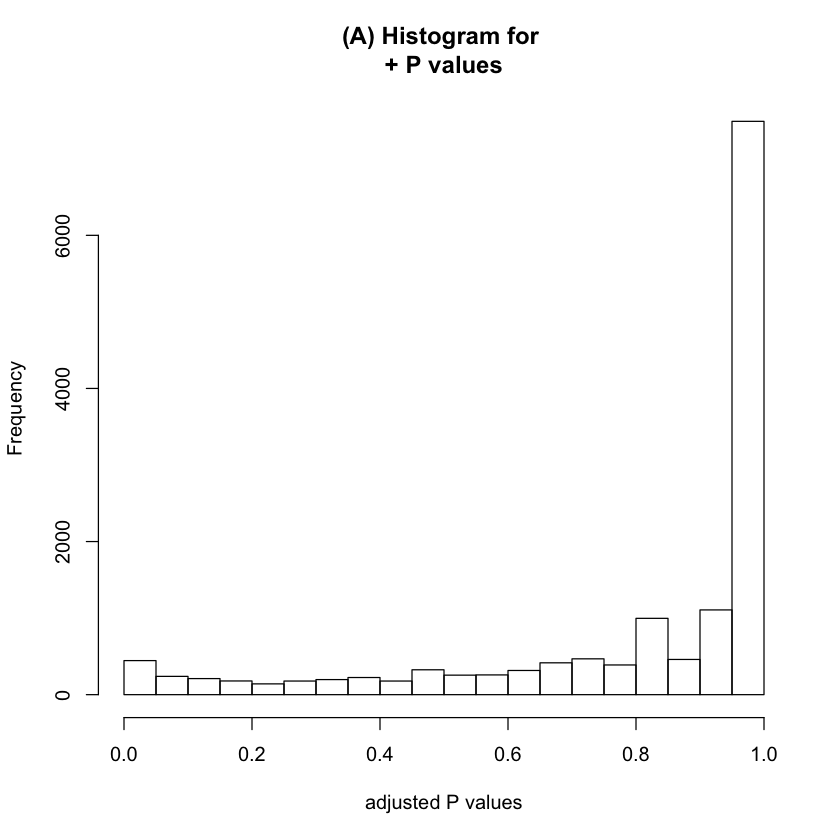

In [69]:
hist(topAll$adj.P.Val, xlab="adjusted P values",main="(A) Histogram for 
+ P values")

In [75]:
clr <- rep("black",nrow(topAll)) # creates a vector for color
clr[which(topAll$adj.P.Val<0.05)] <- "red"# sets color for DE to red

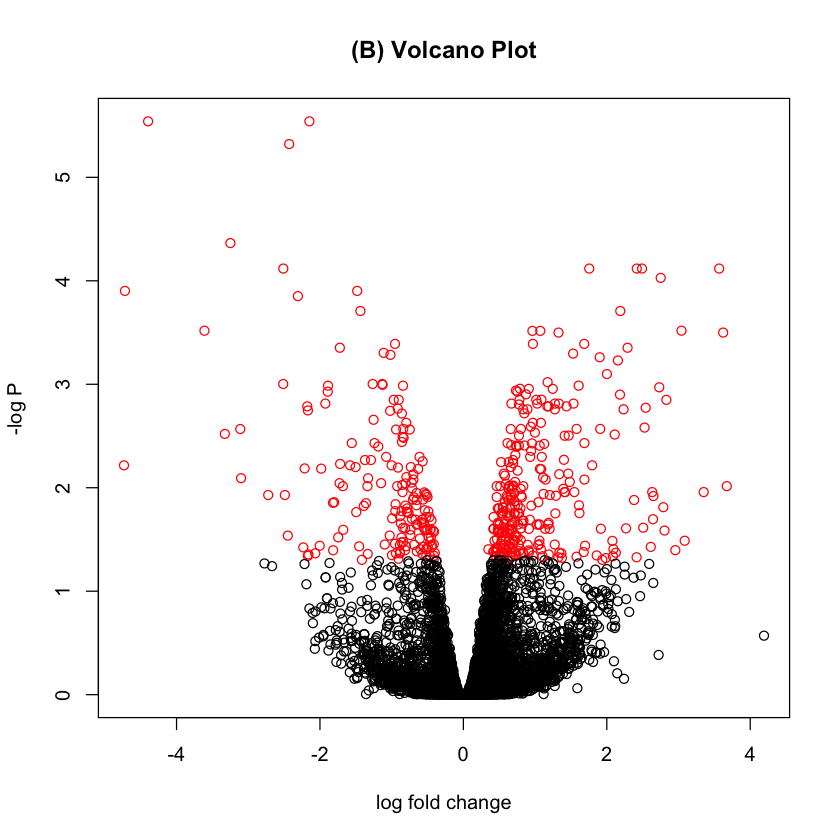

In [87]:
plot(x = topAll$logFC, y = -log10(topAll$adj.P.Val), col = clr, xlab = "log fold change", ylab = "-log P",main = "(B) Volcano Plot") 

- 结果显示，我们有445个标签显示DE标签，也就是说，在两种情况下，标签的表达能力明显增强。我们可以检查这些中有多少显示出更高的折线变化。在下面操作中，我们可以看到，59个标签显示了超过两倍的变化(正的或负的)。

In [84]:
 rownames(topAll[which(topAll$adj.P.Val<0.05&abs(topAll$logFC) > 2),])

[1] "FBgn0029167" "FBgn0035085" "FBgn0039155" "FBgn0011260" "FBgn0034736"
 [6] "FBgn0029896" "FBgn0000071" "FBgn0051092" "FBgn0026562" "FBgn0003501"
[11] "FBgn0033764" "FBgn0035189" "FBgn0034434" "FBgn0037290" "FBgn0260011"
[16] "FBgn0024288" "FBgn0051642" "FBgn0034438" "FBgn0038832" "FBgn0032405"
[21] "FBgn0020248" "FBgn0052407" "FBgn0261284" "FBgn0040827" "FBgn0038198"
[26] "FBgn0030598" "FBgn0039827" "FBgn0050463" "FBgn0039593" "FBgn0037754"
[31] "FBgn0030763" "FBgn0085359" "FBgn0033065" "FBgn0030041" "FBgn0010387"
[36] "FBgn0038237" "FBgn0032436" "FBgn0053318" "FBgn0038012" "FBgn0063667"
[41] "FBgn0030964" "FBgn0033760" "FBgn0051555" "FBgn0046258" "FBgn0037143"
[46] "FBgn0259236" "FBgn0037223" "FBgn0037191" "FBgn0002578" "FBgn0051663"
[51] "FBgn0052700" "FBgn0039937" "FBgn0033733" "FBgn0050324" "FBgn0034898"
[56] "FBgn0028939" "FBgn0051776" "FBgn0032770" "FBgn0020639"

---

## 8. Enriching RNAseq data with GO terms 用GO术语丰富RNAseq数据

- 来自NGS的RNAseq数据提供了关于细胞转录的详细信息。
除了测量转录的表达水平，它们还提供信息
关于选择性剪接、等位基因特异性表达等。
因此，RNAseq数据提供了细胞中差异表达的更全面的图像。
但是，添加功能方面可以通过统计稳健性进一步细化此分析。
此菜谱的目的是演示如何在GO术语中突出显示RNAseq数据。

（1） 加载goseq and edgeR

In [89]:
library(goseq)
library(edgeR)

Loading required package: BiasedUrn

Loading required package: geneLenDataBase





In [91]:
head(supportedGenomes())  #这个包支持的基因组

,db,species,date,name,AvailableGeneIDs
,<chr>,<chr>,<chr>,<chr>,<chr>
2,hg19,Human,Feb. 2009,Genome Reference Consortium GRCh37,"ccdsGene,ensGene,exoniphy,geneSymbol,knownGene,nscanGene,refGene,xenoRefGene"
3,hg18,Human,Mar. 2006,NCBI Build 36.1,"acembly,acescan,ccdsGene,ensGene,exoniphy,geneSymbol,geneid,genscan,knownGene,knownGeneOld3,refGene,sgpGene,sibGene,xenoRefGene"
4,hg17,Human,May 2004,NCBI Build 35,"acembly,acescan,ccdsGene,ensGene,exoniphy,geneSymbol,geneid,genscan,knownGene,refGene,sgpGene,vegaGene,vegaPseudoGene,xenoRefGene"
5,hg16,Human,Jul. 2003,NCBI Build 34,"acembly,ensGene,exoniphy,geneSymbol,geneid,genscan,knownGene,refGene,sgpGene"
21,felCat3,Cat,Mar. 2006,Broad Institute Release 3,"ensGene,geneSymbol,geneid,genscan,nscanGene,refGene,sgpGene,xenoRefGene"
26,panTro2,Chimp,Mar. 2006,CGSC Build 2.1,"ensGene,geneSymbol,genscan,nscanGene,refGene,xenoRefGene"


(2)从goseq包中加载您将用于分析的数据

In [92]:
myData <- read.table(system.file("extdata", "Li_sum.txt", package="goseq"), 
                     sep = '\t', header = TRUE, stringsAsFactors = FALSE,row.names=1)

In [93]:
head(myData)

,lane1,lane2,lane3,lane4,lane5,lane6,lane8
,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000215688,0,0,0,0,0,0,0
ENSG00000215689,0,0,0,0,0,0,0
ENSG00000220823,0,0,0,0,0,0,0
ENSG00000242499,0,0,0,0,0,0,0
ENSG00000224938,0,0,0,0,0,0,0
ENSG00000239242,0,0,0,0,0,0,0


(3)数据中的前四列是对照，最后三列是处理
样本。
输入以下命令将这些属性赋值给数据:

In [94]:
myTreat <- factor(rep(c("Control","Treatment"),times = c(4,3)))

（4）使用所有的count数据和通过edgeR库创建一个DGElist对象

In [95]:
 myDG <- DGEList(myData,lib.size = colSums(myData),group = myTreat)

（5）使用DGElist对象，先估计数据中的离散度，然后是一个p值测试

In [96]:
myDisp <- estimateCommonDisp(myDG)
mytest <- exactTest(myDisp)

<font color = blue>(6)利用分析得到的基因进行富集。提取基因
期望的p值和对数倍变化情况与相应的基因
命名，创建一个命名向量，如下所示:

In [97]:
myTags <- as.integer(p.adjust(mytest$table$PValue[mytest$table$logFC!=0], method="BH") < 0.05)

In [98]:
names(myTags) <- row.names(mytest$table[mytest$table$logFC!=0,])  #创建命名向量

In [101]:
table(myTags)   #在DE或非DE

myTags
    0     1 
19535  3208 

（7）接下来，计算基于它们的一组基因的概率加权函数
状态如下:

Loading hg19 length data...

Warning message in pcls(G):
“initial point very close to some inequality constraints”


,DEgenes,bias.data,pwf
,<int>,<dbl>,<dbl>
ENSG00000230758,0,247,0.03757470
ENSG00000182463,0,3133,0.20436865
ENSG00000124208,0,1978,0.16881769
ENSG00000230753,0,466,0.06927243
ENSG00000224628,0,1510,0.15903532
ENSG00000125835,0,954,0.12711992


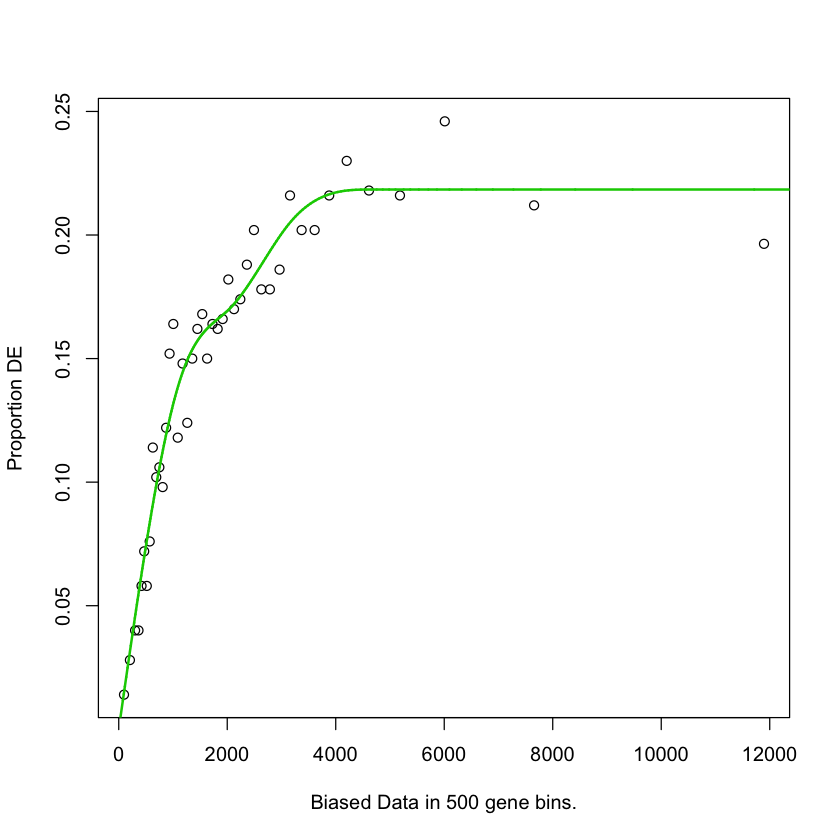

In [102]:
wtFunc <- nullp(myTags,"hg19","ensGene")
head(wtFunc)

（8）利用所得的结果计算富集值

In [103]:
myEnrich_wall <- goseq(wtFunc,"hg19","ensGene", test.cats=c("GO:BP"))

Fetching GO annotations...

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: IRanges

Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:geneLenDataBase’:

    unfactor


The following object is masked from ‘package:base’:

    expand.grid




For 9426 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



In [104]:
 head(myEnrich_wall)

,category,over_represented_pvalue,under_represented_pvalue,numDEInCat,numInCat,term,ontology
,<chr>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>
1674,GO:0006793,3.599915e-08,1,620,2554,phosphorus metabolic process,BP
1550,GO:0006614,4.732072e-08,1,34,95,SRP-dependent cotranslational protein targeting to membrane,BP
57,GO:0000278,5.978181e-08,1,243,881,mitotic cell cycle,BP
1675,GO:0006796,6.736033e-08,1,612,2528,phosphate-containing compound metabolic process,BP
1549,GO:0006613,7.959581e-08,1,35,99,cotranslational protein targeting to membrane,BP
2127,GO:0008283,8.843440e-08,1,345,1314,cell proliferation,BP


In [106]:
library(GO.db)  #用GO包查看目录

In [109]:
GOTERM[[myEnrich_wall$category[1]]]

GOID: GO:0006793
Term: phosphorus metabolic process
Ontology: BP
Definition: The chemical reactions and pathways involving the
    nonmetallic element phosphorus or compounds that contain
    phosphorus, usually in the form of a phosphate group (PO4).
Synonym: phosphorus metabolism

> 本节的大部分内容(到第9步为止)与前一个节方法相似，都是处理edgeR包。
在第9步之前，我们计算感兴趣的基因或标记，并获得标记的Ensembl id。
第10步中使用的goseq函数获取了第9步中获得的Ensembl基因的GO类别。在这个配方中，我们只使用了生物过程类别，但是对于其他类别，我们可以使用GO:CC或GO:MF值。 除了获取GO注释外，goseq函数还计算了p值的过表达和不足。
最后，使用GO.db包为检索到的类别提供了实际的GO术语详细信息。

---

## 9, The KEGG enrichment of sequence data

这个和前一个很相似。但是，在这个配方中，我们的目标是找到KEGG注释来代替GO类别。

（1）Start with loading the required packages, goseq and edgeR

In [110]:
library(goseq)
library(edgeR)
library(org.Hs.eg.db)

（2）从goseq包加载数据

In [116]:
myData <- read.table(system.file("extdata", "Li_sum.txt", package = 'goseq'), sep = '\t', header = TRUE, stringsAsFactors = 
FALSE,row.names = 1)

（3）数据中的前四列是对照，最后三列是处理
样本。将这些属性分配给数据并执行差异标记
计算如下:

In [117]:
 myTreat <- factor(rep(c("Control","Treatment"),times = c(4,3)))

In [118]:
myData

,lane1,lane2,lane3,lane4,lane5,lane6,lane8
,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000215688,0,0,0,0,0,0,0
ENSG00000215689,0,0,0,0,0,0,0
ENSG00000220823,0,0,0,0,0,0,0
ENSG00000242499,0,0,0,0,0,0,0
ENSG00000224938,0,0,0,0,0,0,0
ENSG00000239242,0,0,0,0,0,0,0
ENSG00000243140,0,0,0,0,0,0,0
ENSG00000240187,0,0,0,0,0,0,0
ENSG00000241444,0,0,0,0,0,0,0


In [121]:
myDG <- DGEList(myData,lib.size = colSums(myData),group = myTreat)    #create `DGElist` object

In [133]:
myDisp <- estimateCommonDisp(myDG)
mytest <- exactTest(myDisp)

> <font color= green> 至此，我们从数据中获取差异表达的标记，就像我们在前面的配方中所做的那样，然后提取感兴趣的基因
(满足p值和log倍数的变化值)

(4)利用分析得到的基因进行富集，从而提取出具有
期望p值和对数倍变化条件及其相应的基因名，
创建一个命名向量如下:

In [124]:
 myTags <- as.integer(p.adjust(mytest$table$PValue[mytest$table$logFC!=0], method = "BH") < 0.05)

In [125]:
names(myTags) <- row.names(mytest$table[mytest$table$logFC!=0,])

(5)Ensembl id转换 Entrez id

In [126]:
 en2eg <- as.list(org.Hs.egENSEMBL2EG)

(6)KEGG id转换Entrez id

In [127]:
 eg2kegg <- as.list(org.Hs.egPATH)

(7)现在要将KEGG和Entrez id映射在一起，输入以下命令:

In [129]:
grepKEGG <- function(id,mapkeys){unique(unlist(mapkeys[id], use.names = FALSE))}


kegg <- lapply(en2eg,grepKEGG,eg2kegg)

> 第5步获得ENSEMBL基因的Entrez映射，然后是第6步中相应的(Entrez基因的)KEGG映射。

(8)要计算概率加权函数，输入以下命令:

Loading hg19 length data...

Warning message in pcls(G):
“initial point very close to some inequality constraints”


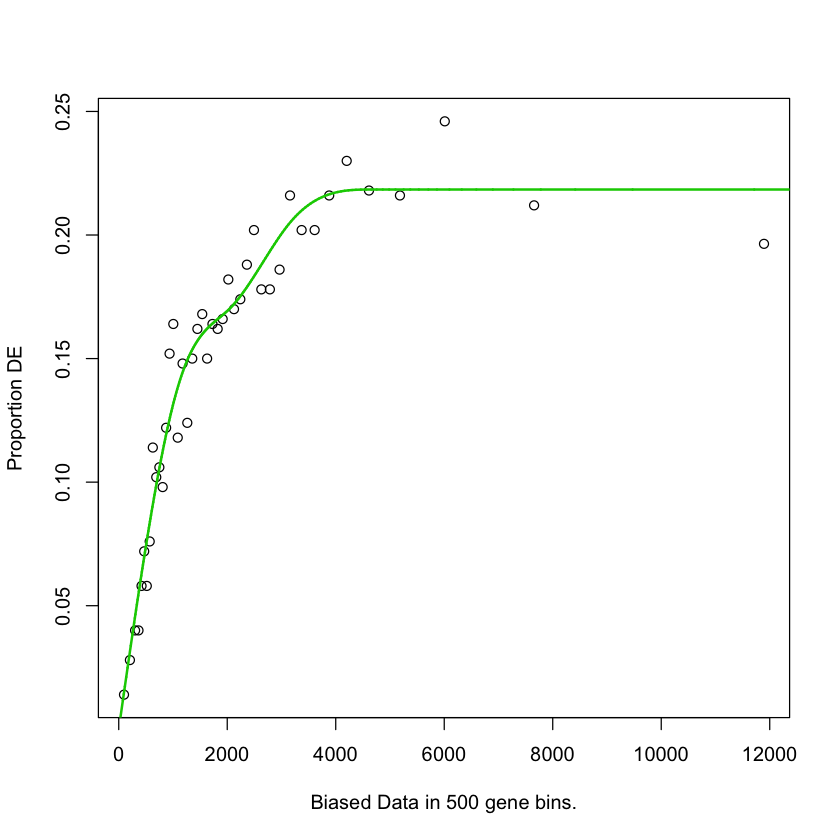

In [131]:
 pwf <- nullp(myTags,"hg19","ensGene")

(10)使用goseq函数和KEGG映射来丰富标签

In [132]:
KEGG <- goseq(pwf,gene2cat = kegg)
head(KEGG)

Using manually entered categories.

For 18658 genes, we could not find any categories. These genes will be excluded.

To force their use, please run with use_genes_without_cat=TRUE (see documentation).

This was the default behavior for version 1.15.1 and earlier.

Calculating the p-values...



,category,over_represented_pvalue,under_represented_pvalue,numDEInCat,numInCat
,<chr>,<dbl>,<dbl>,<int>,<int>
88,03010,6.331426e-06,0.9999980,29,87
77,00900,2.393680e-04,0.9999710,10,15
113,04115,8.178449e-04,0.9996829,26,64
175,04964,2.152488e-03,0.9995921,10,17
27,00330,3.673147e-03,0.9986576,18,44
20,00250,5.204967e-03,0.9984341,13,28


 > 我们从整个列表中提取有趣基因的KEGG注释
并计算浓缩分数。

---

## 9.Analyzing methylation data 分析甲基化数据

 - DNA甲基化数据可以作为一个工具，以检测表观遗传标记，其中有丝分裂遗传的详细机制已被描述。
它通常是通过甲基化特异性DNA测序或微阵列数据表观遗传调控来完成的。
NGS和微阵列技术的最新进展使得在高分辨率和大量样本中绘制全基因组DNA甲基化图谱成为可能。
分析甲基化数据的一个共同目标是在比较控制和治疗条件时识别差异甲基化区域(dmr)。
本节旨在解决这个问题。

（1） we will use the methyAnalysis package and the built-in dataset

In [134]:
library(methyAnalysis)
data(exampleMethyGenoSet)

Loading required package: grid

Loading required package: GenomeInfoDb

Warning message:
“package ‘GenomeInfoDb’ was built under R version 3.6.3”
Loading required package: GenomicRanges

Setting options('download.file.method.GEOquery'='auto')

Setting options('GEOquery.inmemory.gpl'=FALSE)

No methods found in package ‘RSQLite’ for request: ‘dbListFields’ when loading ‘lumi’

No methods found in package 'genoset' for request: 'toGenomeOrder' when loading 'methyAnalysis'



(2)查看数据信息

In [135]:
slotNames(exampleMethyGenoSet)  # 对象数据的根目录类别

dim(exprs(exampleMethyGenoSet)) # 对象数据二维行列

str(exampleMethyGenoSet)        # 对象数据结构

head(locData(exampleMethyGenoSet)) 

pData(exampleMethyGenoSet)  #表型数据

class(exampleMethyGenoSet)      # 对象数据类别

colnames(exampleMethyGenoSet)   # 对象数据的行名

exampleMethyGenoSet             # 对象数据内容

[1] "history"         "annotation"      "rowRanges"       "colData"        
[5] "assays"          "NAMES"           "elementMetadata" "metadata"

[1] 4243    8

Formal class 'MethyGenoSet' [package "methyAnalysis"] with 8 slots
  ..@ history        :'data.frame':	0 obs. of  4 variables:
  .. ..$ submitted  : 'AsIs' logi(0) 
  .. ..$ finished   : 'AsIs' logi(0) 
  .. ..$ command    : 'AsIs' logi(0) 
  .. ..$ lumiVersion: 'AsIs' logi(0) 
  ..@ annotation     : chr "IlluminaHumanMethylation450k.db"
  ..@ rowRanges      :Formal class 'GRanges' [package "GenomicRanges"] with 7 slots


Warning message:
"Not a validObject(): "elementType"槽名不存在于"GRanges"类别对象中"


  .. .. ..@ seqnames       :Formal class 'Rle' [package "IRanges"] with 4 slots
  .. .. .. .. ..@ values         : Factor w/ 1 level "chr21": 1
  .. .. .. .. ..@ lengths        : int 4243
  .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .. ..@ metadata       : list()
  .. .. ..@ strand         :Formal class 'Rle' [package "IRanges"] with 4 slots
  .. .. .. .. ..@ values         : Factor w/ 3 levels "+","-","*": 3
  .. .. .. .. ..@ lengths        : int 4243
  .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .. ..@ metadata       : list()
  .. .. ..@ ranges         :Formal class 'IRanges' [package "IRanges"] with 6 slots
  .. .. .. .. ..@ start          : int [1:4243] 10882029 10883548 10884748 10884967 10884969 10885409 10888524 10891858 10895603 10895780 ...
  .. .. .. .. ..@ width          : int [1:4243] 1 1 1 1 1 1 1 1 1 1 ...
  .. .. .. .. ..@ NAMES          : chr [1:4243] "cg17035109" "cg06187584" "cg12459059" "cg25450479" ...
  .. .. .. .. ..@ elementType    : chr "integer"
  ..

ERROR: Error in locData(exampleMethyGenoSet): 没有"locData"这个函数


（3）平滑数据。 这里设置为200

In [138]:
 methylSmooth <- smoothMethyData(exampleMethyGenoSet, winSize = 200) 

Smoothing Chromosome chr21 ...


In [139]:
 attr(methylSmooth,'windowSize')

[1] 200

（4）从pData组件中提取样本条件如下:

In [141]:
conditons <- colData(exampleMethyGenoSet)$SampleType

(5)取上一步的输入数据和样本类型，检测数据中的dmr

In [142]:
myDMR <- detectDMR.slideWin(exampleMethyGenoSet, sampleType=conditons) #Might get some warning messages

Smoothing Chromosome chr21 ...


In [143]:
head(myDMR)

GRanges object with 6 ranges and 11 metadata columns:
             seqnames    ranges strand |    PROBEID         difference
                <Rle> <IRanges>  <Rle> |   <factor>          <numeric>
  cg17035109    chr21  10882029      * | cg17035109  -1.84116050891237
  cg06187584    chr21  10883548      * | cg06187584 -0.456605878544024
  cg12459059    chr21  10884748      * | cg12459059 -0.359117942730594
  cg25450479    chr21  10884967      * | cg25450479 -0.359117942730594
  cg23347501    chr21  10884969      * | cg23347501 -0.359117942730594
  cg03661019    chr21  10885409      * | cg03661019 -0.353266150910433
                        p.value          p.adjust             tscore
                      <numeric>         <numeric>          <numeric>
  cg17035109 0.0627644943115837  0.18884880818101  -2.28040907618597
  cg06187584  0.416014860951571  0.61495957661053 -0.873425189908341
  cg12459059  0.365421521707119 0.562790422031127 -0.978927000428536
  cg25450479  0.365421521707119 0

(6)要识别重要的dmr，在输出中运行identifySigDMR:

In [144]:
 mySigDMR <- identifySigDMR(myDMR)

In [145]:
dmr_anno <- annotateDMRInfo(mySigDMR,'TxDb.Hsapiens.UCSC.hg19.knownGene') #Get the annotation information for the regions from UCSC

Loading required package: TxDb.Hsapiens.UCSC.hg19.knownGene

Loading required package: GenomicFeatures



In [147]:
export.DMRInfo(dmr_anno, savePrefix='testExample')  #导出分析结果

>我们在此菜谱中使用的示例数据是eSet类的扩展，包含用于不同类型信息(如样本、染色体和基因组范围)的插槽。
我们的分析从数据平滑开始。
该函数根据定义的窗口(这里是200)来考虑附近CpG站点的相关性，从而降低了噪声。
有了较少的干扰数据，detectDMR。slideWin根据t检验或wilcox检验检查区域(平滑)是否被差异甲基化，然后通过调用getContinuousRegion函数合并得到连续区域。
用基因组数据注释的结果最终导出为CSV文件。

- 一个不同的甲基化区域，我们的目标是在这个食谱中找到，是一个大多数CpG位点甲基化的区域。
我们在这里所做的是检测来自examplemethgenoset对象的探针甲基化状态。
最后，我们将这些区域映射到染色体图上。
在这个配方中，我们看到SIM2、ERG、DIP2等区域在21号染色体上被大量甲基化，p值小于0.05。
菜谱的输入数据是一个eSet对象。
然而，它可以是其他格式，如CSV或文本文件。
从这些文件创建eSet的方法已经在本章中解释过了
用R语言分析芯片数据

---

## 10. Analyzing ChipSeq data

- 染色质免疫沉淀测序(ChipSeq)是一个强大的方法，以确定基因组范围内的DNA结合位点的蛋白质的利益。
它常被用于确定转录因子、dna结合酶、组蛋白、伴侣蛋白或核小体的结合位点。
生成ChipSeq数据的工作流从交叉链接绑定开始
蛋白质和染色质。
染色质是片段化的，与一个蛋白质结合的DNA片段通过特异性抗体捕获。
捕获片段的末端使用ng排序。
序列DNA的计算映射导致了
识别这些片段的基因组位置，阐明它们在DNA中的作用
蛋白质相互作用和表观遗传学研究。
ChipSeq数据由FASTQ文件格式的短读组成。
文件的每五行后面都有一个简短的读操作。
本配方将处理R中ChipSeq数据的分析。

(1)load   chipseq package,使用内置数据

In [148]:
library(TxDb.Mmusculus.UCSC.mm9.knownGene)  
library(chipseq)  
data(cstest)        #use the built-in package dataset named `cstest`
cstest    

Loading required package: ShortRead

Loading required package: BiocParallel

Loading required package: Biostrings

Loading required package: XVector


Attaching package: 'Biostrings'


The following object is masked from 'package:base':

    strsplit


Loading required package: Rsamtools

Loading required package: GenomicAlignments

Loading required package: SummarizedExperiment

Loading required package: DelayedArray

Loading required package: matrixStats


Attaching package: 'matrixStats'


The following object is masked from 'package:methyAnalysis':

    rowRanges


The following objects are masked from 'package:Biobase':

    anyMissing, rowMedians



Attaching package: 'DelayedArray'


The following objects are masked from 'package:matrixStats':

    colMaxs, colMins, colRanges, rowMaxs, rowMins, rowRanges


The following objects are masked from 'package:base':

    aperm, apply, rowsum



Attaching package: 'ShortRead'


The following objects are masked from 'package:locfit':

  

GRangesList object of length 2:
$ctcf
GRanges object with 450096 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]    chr10     3012936-3012959      +
       [2]    chr10     3012941-3012964      +
       [3]    chr10     3012944-3012967      +
       [4]    chr10     3012955-3012978      +
       [5]    chr10     3012963-3012986      +
       ...      ...                 ...    ...
  [450092]    chr12 121239376-121239399      -
  [450093]    chr12 121245849-121245872      -
  [450094]    chr12 121245895-121245918      -
  [450095]    chr12 121246344-121246367      -
  [450096]    chr12 121253499-121253522      -
  -------
  seqinfo: 35 sequences from an unspecified genome

$gfp
GRanges object with 295385 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]    chr10     3002512-3002535      +
       [2]    chr10     300

（2）估计片段长度

In [149]:
estimate.mean.fraglen(cstest$ctcf)

chr10    chr11    chr12 
179.6794 172.4884 181.6732

（3）扩展您的片段以覆盖序列中的绑定位置

In [150]:
ctcf_ext <- resize(cstest$ctcf, width = 200)
gfp_ext <- resize(cstest$gfp, width = 200)

- 对这些信息的一个有用的总结是覆盖率，即每种信息的次数
基因组中的碱基被这些间隔中的一个覆盖，可以计算
如下:

In [151]:
cov_ctcf <- coverage(ctcf_ext)
cov_gfp <- coverage(gfp_ext)

（4）现在，使用以下函数为感兴趣的区域创建一个称为岛屿的图。
它们是连续的片段:x轴显示深度，而y轴显示
对应的日志计数(总体上，图中显示了样本数据的覆盖率):

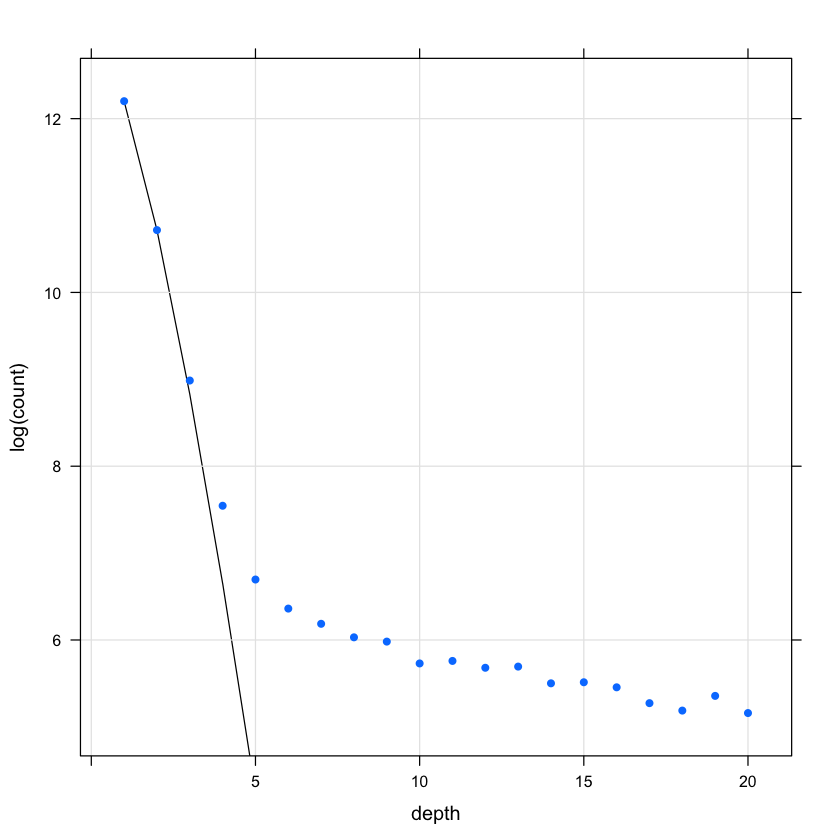

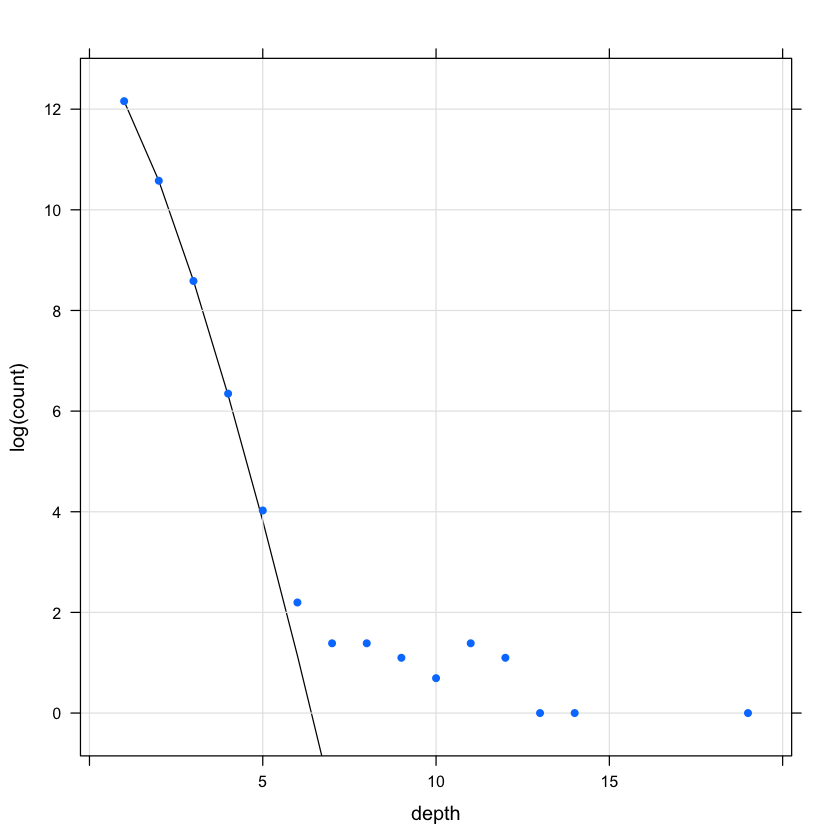

In [152]:
par(mfrow = c(2, 1))
islandDepthPlot(cov_ctcf)
islandDepthPlot(cov_gfp)

（5）现在，计算一个期望的fdr(这里，0.01)的峰截止时间如下:

In [153]:
peakCutoff(cov_ctcf, fdr = 0.01)

[1] 5.091909

In [154]:
peakCutoff(cov_gfp, fdr = 0.01)

[1] 6.979273

(6)使用此值，确定一个截断值(7)，以便获得具有的峰值
ctcf和gfp两种泳道的数据段覆盖率都很高，如下图所示
(请注意，选择的截距是基于你在5.09和6.97以上的计算):With this value, decide a cut-off value (7) to be used in order to get the peaks with 
high coverage in the segments of the data for both lanes, ctcf and gfp, as follows 
(note that the chosen cut off is based on your computation above 5.09 and 6.97):

In [155]:
peaks_ctcf <- slice(cov_ctcf, lower = 7)
peaks_gfp <- slice(cov_gfp, lower = 7)

(7现在，用下面的函数计算微分峰来确定哪一个
两个样品的峰是不同的:

In [156]:
 peakSummary <- diffPeakSummary(peaks_gfp, peaks_ctcf)
head(data.frame(peakSummary))

,seqnames,start,end,width,strand,comb.max,sums1,sums2,maxs1,maxs2
,<fct>,<int>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<int>
1,chr10,3012944,3013140,197,*,11,0,1911,0,11
2,chr10,3135027,3135029,3,*,7,0,21,0,7
3,chr10,3234798,3234896,99,*,10,0,910,0,10
4,chr10,3234924,3234933,10,*,7,0,70,0,7
5,chr10,3270010,3270301,292,*,20,164,4072,1,19
6,chr10,3277660,3277861,202,*,13,0,1897,0,13


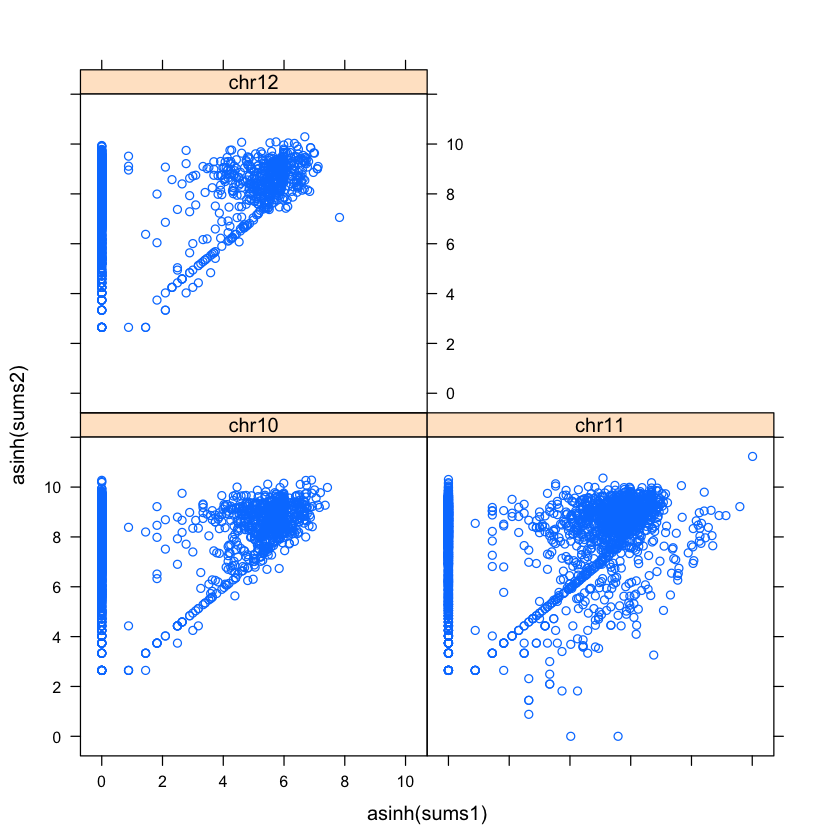

In [160]:
xyplot(asinh(sums2) ~ asinh(sums1) | seqnames, data = as.data.frame(peakSummary))

-  Now, you have the peaks of your interest. 
Find if they are in the region of interest (promoter region) using the following commands:

In [161]:
gregions <- transcripts(TxDb.Mmusculus.UCSC.mm9.knownGene)
promoters <- flank(gregions, 1000, both = TRUE)
peakSummary$inPromoter <- peakSummary %over% promoters

In [162]:
which(peakSummary$inPromoter)

[1]    2   14   41   51  100  101  110  124  126  130  133  141  155  156  157
 [16]  158  175  176  177  180  184  185  211  212  213  217  218  257  273  276
 [31]  299  306  307  315  318  319  325  327  328  358  361  362  370  371  375
 [46]  381  386  432  456  460  461  493  499  502  513  527  555  556  566  595
 [61]  596  604  606  607  621  622  623  628  652  657  663  665  676  696  697
 [76]  701  710  715  725  824  825  877  900  914  915  918  919  925  938  942
 [91]  963  976  977  993  996  998 1008 1027 1033 1034 1036 1037 1040 1051 1052
[106] 1055 1056 1057 1059 1067 1068 1071 1072 1076 1079 1080 1087 1091 1108 1109
[121] 1110 1112 1114 1115 1124 1127 1131 1144 1159 1166 1175 1182 1195 1211 1226
[136] 1263 1288 1289 1290 1292 1308 1339 1346 1370 1386 1412 1413 1414 1425 1436
[151] 1463 1491 1495 1496 1497 1498 1549 1556 1557 1573 1580 1590 1600 1608 1609
[166] 1620 1647 1651 1685 1686 1705 1715 1716 1721 1740 1741 1776 1783 1795 1796
[181] 1797 1802 1803 1804 1831 1834 1836 1838 1845 1847 1848 1850 1855 1857 1865
[196] 1866 1869 1870 1875 1878 1881 1882 1883 1937 1938 1939 1940 1941 1942 1943
[211] 1944 1966 1967 1968 1969 2034 2035 2036 2037 2038 2039 2040 2051 2053 2058
[226] 2063 2066 2081 2093 2094 2095 2098 2102 2127 2134 2137 2150 2153 2154 2159
[241] 2164 2172 2182 2183 2202 2218 2235 2236 2237 2238 2240 2248 2268 2300 2302
[256] 2330 2334 2336 2338 2339 2365 2367 2372 2375 2378 2379 2380 2412 2413 2419
[271] 2452 2503 2560 2586 2591 2592 2637 2656 2659 2666 2667 2675 2697 2703 2711
[286] 2712 2714 2723 2763 2770 2771 2785 2804 2832 2846 2893 2899 2900 2911 2918
[301] 2919 2929 2932 2946 2948 2954 2970 2974 2988 2996 3006 3022 3029 3034 3036
[316] 3047 3048 3129 3132 3138 3149 3150 3158 3162 3164 3172 3176 3190 3193 3210
[331] 3211 3215 3216 3218 3226 3229 3230 3233 3236 3242 3245 3255 3256 3260 3264
[346] 3277 3280 3281 3290 3310 3316 3317 3318 3326 3329 3330 3331 3334 3353 3356
[361] 3357 3389 3391 3392 3393 3394 3402 3423 3427 3432 3442 3452 3479 3488 3497
[376] 3504 3505 3526 3560 3564 3570 3573 3579 3586 3587 3588 3598 3599 3631 3632
[391] 3633 3635 3638 3648 3680 3688 3693 3719 3730 3751 3754 3755 3766 3768 3771
[406] 3778 3792 3793 3801 3810 3847 3862 3864 3865 3866 3870 3871 3884 3890 3895
[421] 3900 3902 3903 3919 3959 3961 3975 3996 3997 4000 4001 4006 4007 4008 4016
[436] 4017 4043 4050 4051 4055 4061 4062 4067 4068 4076 4078 4094 4101 4102 4130
[451] 4133 4182 4184 4186 4191 4192 4199 4201 4217 4221 4226 4230 4236 4238 4244
[466] 4263 4265 4266 4270 4280 4281 4290 4295 4301 4321 4322 4329 4331 4332 4333
[481] 4340 4341 4356 4368 4371 4380 4381 4389 4402 4411 4414 4415 4419 4442 4445
[496] 4477 4493 4495 4499 4536 4558 4559 4562 4602 4603 4605 4622 4628 4630 4631
[511] 4632 4633 4634 4640 4645 4655 4659 4661 4668 4672 4675 4676 4678 4679 4695
[526] 4696 4699 4706 4707 4713 4733 4755 4756 4759 4761 4762 4765 4766 4768 4769
[541] 4787 4792 4816 4820 4825 4836 4846 4850 4861 4862 4874 4875 4892 4894 4895
[556] 4897 4912 4914 4919 4920 4938 4939 4946 4950 4952 4966 4979 4980 4982 4989
[571] 4994 5011 5012 5017 5019 5027 5037 5050 5066 5079 5100 5103 5124 5132 5133
[586] 5139 5140 5153 5165 5166 5180 5181 5229 5246 5247 5260 5273 5308 5312 5335
[601] 5362 5395 5405 5410 5411 5412 5413 5438 5441 5455 5456 5467 5479 5480 5489
[616] 5491 5505 5506 5525 5526 5535 5567 5603 5604 5627 5645 5647 5651 5656 5657
[631] 5660 5661 5674 5683 5684 5697 5698 5699 5701 5706 5728 5731 5732 5739 5740
[646] 5758 5759 5763 5779 5792 5794 5815 5825 5909 5947 5948 5962 5979 5996 6022
[661] 6047 6068 6130 6131 6148 6161 6182 6224 6259 6267 6268 6309 6313 6318 6322
[676] 6327 6328 6349 6361 6362

 > 在这个配方中，输入的数据来自3条染色体(10、11和12)和代表ctcf和gfp下拉的2条泳道。
我们分析的目的是找出两个车道(样本)中哪些峰是不同的。本配方中介绍的方法为数据找到覆盖向量，并为其中的峰值计算统计分数。
我们首先通过将读取扩展到绑定站点来查找两个lane的覆盖范围。
然后，我们根据期望的fdr(0.01，如步骤7所示)，根据截止值定义我们的峰值。
diffPeakSummary函数然后将这两个车道的一组峰值组合起来并对它们进行汇总。
最后，我们在步骤11中将这些峰映射到参考基因组，并选择位于启动子区域的峰，这些峰对于寻找结合位点很有意义(步骤12)。

---

## 12. Visualizations for NGS data NGS数据的可视化

 - NGS质量评估可视化
 - 甲基化map